In [1]:
%store -r __import

In [2]:
__import

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [5]:
train = pd.read_csv('/home/tuts/datasets/titanic/train.csv')
test = pd.read_csv('/home/tuts/datasets/titanic/test.csv')

In [6]:
print(f'Train shape {train.shape}')
print(f'Test shape {test.shape}')

Train shape (891, 12)
Test shape (418, 11)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


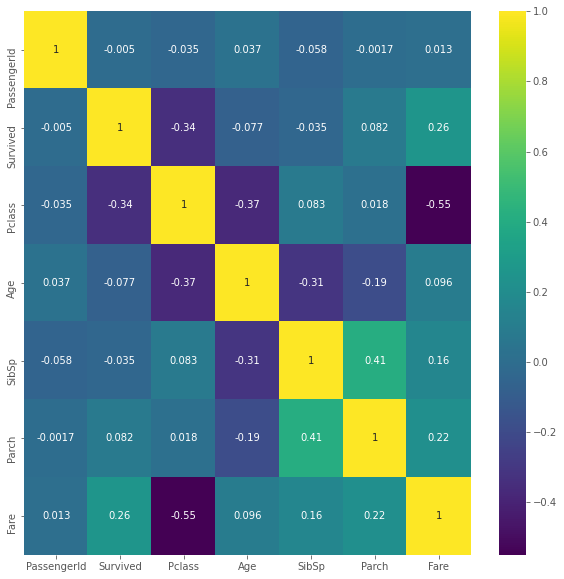

In [8]:
corr = train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='viridis');

In [9]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
train[train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [66]:
def impute_median_sex_age_fare(df):
    male_passangers = df[df['Sex'] == 'male']
    female_passangers = df[df['Sex'] == 'female']
    male_passangers.Age.fillna(male_passangers.Age.median(), inplace=True)
    female_passangers.Age.fillna(female_passangers.Age.median(), inplace=True)
    new_df = pd.concat([male_passangers, female_passangers])
    new_df.Fare.fillna(new_df.Fare.median(), inplace=True)
    return new_df.sample(frac=1, random_state=42)

def impute_mode_embarked(df):
    print(df.Embarked.mode())
    df.Embarked.fillna('S', inplace=True)
    return df
    
def create_new_features(df):
    df['isincabin'] = df['Cabin'].notna().astype('int')
    df['is_underage'] = (df.Age < 18).astype('int')
    df['is_midlife'] = ((df.Age > 18) & (df.Age < 60)).astype('int')
    df['is_elder'] = (df.Age > 60).astype('int')
    df = pd.concat([df, pd.get_dummies(df.Sex)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.Embarked)], axis=1)
    df.drop(['Sex'], axis=1, inplace=True)
    df.drop(['Embarked'], axis=1, inplace=True)
    return df

In [60]:
female_passangers = train[train['Sex']=='female']
female_passangers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [12]:
female_passangers.Sex.value_counts()

female    314
Name: Sex, dtype: int64

In [13]:
female_passangers.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             53
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          217
Embarked         2
dtype: int64

In [14]:
female_passangers.Age.describe()

count    261.000000
mean      27.915709
std       14.110146
min        0.750000
25%       18.000000
50%       27.000000
75%       37.000000
max       63.000000
Name: Age, dtype: float64

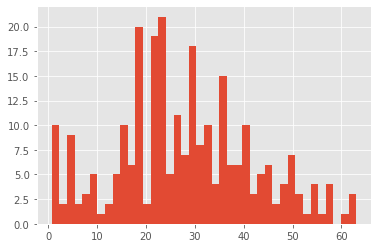

In [15]:
plt.hist(female_passangers.Age, bins=40);

In [16]:
female_passangers.Age.mode()

0    24.0
dtype: float64

In [17]:
female_passangers.Age.fillna(female_passangers.Age.median(), inplace=True)
female_passangers.isna().sum()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          217
Embarked         2
dtype: int64

In [18]:
male_passangers = train[train['Sex'] == 'male']
male_passangers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [19]:
male_passangers.Age.describe()

count    453.000000
mean      30.726645
std       14.678201
min        0.420000
25%       21.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

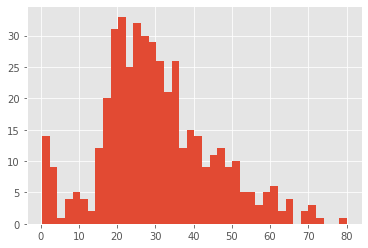

In [20]:
plt.hist(male_passangers.Age, bins=40);

In [21]:
male_passangers.Age.mode()

0    19.0
1    25.0
2    28.0
dtype: float64

In [22]:
male_passangers.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            124
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          470
Embarked         0
dtype: int64

In [23]:
male_passangers.Age.fillna(male_passangers.Age.median(), inplace=True)
male_passangers.isna().sum()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          470
Embarked         0
dtype: int64

In [24]:
train_after_age_fill = pd.concat([male_passangers, female_passangers])

In [25]:
train_after_age_fill['isincabin'] = train_after_age_fill['Cabin'].notna().astype('int')
train_after_age_fill.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isincabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,0,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,NaN,Q,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0


In [26]:
train_without_cabin = train_after_age_fill.drop('Cabin', axis=1)
train_without_cabin.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,isincabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0
5,6,0,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,Q,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,0


In [27]:
train_without_cabin['is_underage'] = (train_without_cabin.Age < 18).astype('int')
train_without_cabin['is_midlife'] = ((train_without_cabin.Age > 18) & (train_without_cabin.Age < 60)).astype('int')
train_without_cabin['is_elder'] = (train_without_cabin.Age > 60).astype('int')

train_without_cabin.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,isincabin,is_underage,is_midlife,is_elder
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,0,1,0
5,6,0,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,Q,0,0,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,1,0,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,0,1,0,0


In [28]:
train_with_sex_encode = pd.concat([train_without_cabin, pd.get_dummies(train_without_cabin.Sex)], axis=1)
train_with_sex_encode.drop(['Sex'], axis=1, inplace=True)
train_with_sex_encode

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,isincabin,is_underage,is_midlife,is_elder,female,male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,0,0,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,0,0,1,0,0,1
5,6,0,3,"Moran, Mr. James",29.0,0,0,330877,8.4583,Q,0,0,1,0,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,S,1,0,1,0,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,S,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",25.0,0,1,230433,26.0000,S,0,0,1,0,1,0
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",22.0,0,0,7552,10.5167,S,0,0,1,0,1,0
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",39.0,0,5,382652,29.1250,Q,0,0,1,0,1,0
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,S,1,0,1,0,1,0


In [67]:
train_test = pd.concat([train, test])
train_test.shape

(1309, 12)

In [68]:
train_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [69]:
train_test.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [70]:
train_test = impute_median_sex_age_fare(train_test)
train_test = impute_mode_embarked(train_test)
train_test.isna().sum()

0    S
dtype: object



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64

In [71]:
train_test = create_new_features(train_test)
train_test.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,isincabin,is_underage,is_midlife,is_elder,female,male,C,Q,S
871,872,1.0,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",47.0,1,1,11751,52.5542,D35,1,0,1,0,1,0,0,0,1
554,555,1.0,3,"Ohman, Miss. Velin",22.0,0,0,347085,7.7750,NaN,0,0,1,0,1,0,0,0,1
368,369,1.0,3,"Jermyn, Miss. Annie",27.0,0,0,14313,7.7500,NaN,0,0,1,0,1,0,0,1,0
358,1250,NaN,3,"O'Keefe, Mr. Patrick",28.0,0,0,368402,7.7500,NaN,0,0,1,0,0,1,0,1,0
98,990,NaN,3,"Braf, Miss. Elin Ester Maria",20.0,0,0,347471,7.8542,NaN,0,0,1,0,1,0,0,0,1


In [72]:
baseline_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'isincabin', 'is_underage', 'is_midlife', 'female']

X = train_test[train_test['Survived'].notna()][baseline_cols]
y = train_test[train_test['Survived'].notna()]['Survived']

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [85]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,isincabin,is_underage,is_midlife,female
405,2,34.0,1,0,21.0000,0,0,1,0
736,3,48.0,1,3,34.3750,0,0,1,1
133,2,29.0,1,0,26.0000,0,0,1,1
857,1,51.0,0,0,26.5500,1,0,1,0
707,1,42.0,0,0,26.2875,1,0,1,0


In [74]:
models = []
for i in range(10, 100, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    models.append(rf)

In [75]:
trained_models = []
predictions = []
for model in models:
    model.fit(X_train, y_train)
    trained_models.append(model)
    y_hat = model.predict(X_val)
    print(f'Accuracy: {accuracy_score(y_val, y_hat)}')
    print(f'Precision: {precision_score(y_val, y_hat)}')
    print(f'Recall: {recall_score(y_val, y_hat)}\n')

Accuracy: 0.7873134328358209
Precision: 0.7289719626168224
Recall: 0.7358490566037735

Accuracy: 0.8134328358208955
Precision: 0.7456140350877193
Recall: 0.8018867924528302

Accuracy: 0.7947761194029851
Precision: 0.7256637168141593
Recall: 0.7735849056603774

Accuracy: 0.7947761194029851
Precision: 0.7217391304347827
Recall: 0.7830188679245284

Accuracy: 0.7985074626865671
Precision: 0.7241379310344828
Recall: 0.7924528301886793

Accuracy: 0.8059701492537313
Precision: 0.7368421052631579
Recall: 0.7924528301886793

Accuracy: 0.7985074626865671
Precision: 0.7280701754385965
Recall: 0.7830188679245284

Accuracy: 0.8059701492537313
Precision: 0.7368421052631579
Recall: 0.7924528301886793

Accuracy: 0.8022388059701493
Precision: 0.7304347826086957
Recall: 0.7924528301886793



In [76]:
best_rf = trained_models[-1]
best_rf

RandomForestClassifier(n_estimators=90, random_state=42)

In [77]:
y_hat = best_rf.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val, y_hat)}')
print(f'Precision: {precision_score(y_val, y_hat)}')
print(f'Recall: {recall_score(y_val, y_hat)}\n')

Accuracy: 0.8022388059701493
Precision: 0.7304347826086957
Recall: 0.7924528301886793



In [78]:
features = baseline_cols
importances = best_rf.feature_importances_
indices = np.argsort(importances)

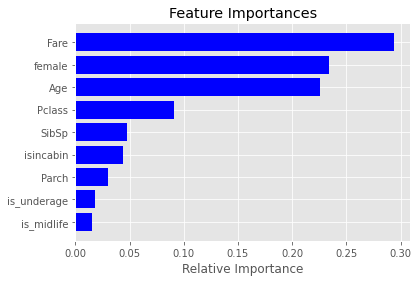

In [79]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance');

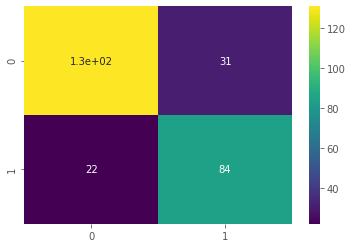

In [80]:
cm = confusion_matrix(y_val, y_hat)
sns.heatmap(cm, annot=True, cmap='viridis');

In [107]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [86]:
X_test = train_test[train_test['Survived'].isna()][baseline_cols]
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,isincabin,is_underage,is_midlife,female
358,3,28.0,0,0,7.7500,0,0,1,0
98,3,20.0,0,0,7.8542,0,0,1,1
31,2,24.0,2,0,31.5000,0,0,1,0
49,3,36.0,0,2,15.9000,0,0,1,1
74,1,35.0,0,0,211.5000,1,0,1,1


In [87]:
submission = best_rf.predict(X_test)
submission

array([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1.